<h1 style="text-align:center;font-size:30px;" > Dstl Satellite Imagery Feature Detection </h1>

<h1> 1. Business Problem </h1>

Advancement in deep learning or specifically computer vision attracted some interest towards differentiating objects in aerial images. This can help in various ways like keeping up to date map, environment monitoring, urban planning and also can also be used in defense and security. One such similar problem statement in kaggle where Defence Science and Technology Laboratory (Dstl) provides 1 Km X 1 Km satellite images and our goal is to detect and classify the types of objects found in the region

Kaggle -> https://www.kaggle.com/c/dstl-satellite-imagery-feature-detection

<h1>2. Data Overview</h1>

-	<b>train_wkt.csv</b> - the WKT format of all the training labels<br>
    •	ImageId - ID of the image<br>
    •	ClassType - type of objects (1-10)<br>
    •	MultipolygonWKT - the labeled area, which is multipolygon geometry represented in WKT format 
    WKT -> Link<br>
-	<b>three_band.zip</b> - the complete dataset of 3-band satellite images. <br>
-	<b>sixteen_band.zip</b> - the complete dataset of 16-band satellite images. <br>
-	<b>grid_sizes.csv</b> - the sizes of grids for all the images<br>
    •	ImageId - ID of the image<br>
    •	Xmax - maximum X coordinate for the image<br>
    •	Ymin - minimum Y coordinate for the image<br>
-	<b>train_geojson.zip</b> - the geojson format of all the training labels (essentially these are the same information as train_wkt.csv) <br>
-   <b>Class Label</b>
    1. Buildings - large building, residential, non-residential, fuel storage facility, fortified building
    2.  Misc. Manmade structures 
    3.  Road 
    4.  Track - poor/dirt/cart track, footpath/trail
    5. Trees - woodland, hedgerows, groups of trees, standalone trees
    6. Crops - contour ploughing/cropland, grain (wheat) crops, row (potatoes, turnips) crops
    7. Waterway 
    8. Standing water
    9. Vehicle Large - large vehicle (e.g. lorry, truck,bus), logistics vehicle
    10. Vehicle Small - small vehicle (car, van), motorbike

<b>Performance metrics</b> - Jaccard coefficient

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import datetime
import seaborn as sns
import os
import tifffile as tiff

In [2]:
wkt_df = pd.read_csv('train_wkt_v4/train_wkt_v4.csv')

In [3]:
len(wkt_df['ImageId'].unique()) #Unique Images

25

total 25 unique Image IDs

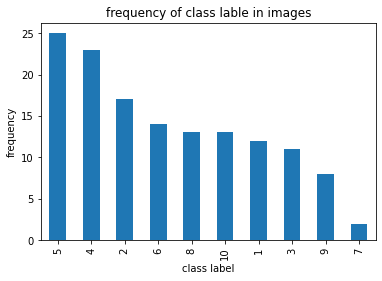

In [4]:
wkt_df[wkt_df['MultipolygonWKT']!='MULTIPOLYGON EMPTY']['ClassType'].value_counts()\
                      .plot.bar(title = 'frequency of class lable in images')
plt.xlabel('class label')
plt.ylabel('frequency')
plt.show()

total 10 unique classes in dataset

In [5]:
from shapely import wkt, affinity
from shapely.wkt import loads

import warnings
warnings.filterwarnings('ignore')

In [15]:
# 3-Band images
def stretch2(band, lower_percent=2, higher_percent=98):
    a = 0 #np.min(band)
    b = 255  #np.max(band)
    c = np.percentile(band, lower_percent)
    d = np.percentile(band, higher_percent)        
    out = a + (band - c) * (b - a) / (d - c)    
    out[out<a] = a
    out[out>b] = b
    return out

def adjust_contrast(x):    
    for i in range(3):
        x[:,:,i] = stretch2(x[:,:,i])
    return x.astype(np.uint8)  

def display_img(ImageID): 
    #Read 3-band image
    rgbfile=os.path.join( 'three_band', '{}.tif'.format(ImageID))              
    rgb = tiff.imread(rgbfile)
    rgb = np.rollaxis(rgb, 0, 3)     

    x = adjust_contrast(rgb).copy()
    ax[1].imshow(x,extent=[0, 0.0092, -0.009, 0])

In [7]:
pol = loads(wkt_df['MultipolygonWKT'][11]) #storing one multipoligon in pol

In [8]:
wkt_df['Multipolygons'] = wkt_df.apply(lambda a: loads(a.MultipolygonWKT), axis=1)
wkt_df['Num_Multipolygons'] = wkt_df.apply(lambda a: len(a['Multipolygons'].geoms), axis=1) #https://stackoverflow.com/questions/38930192/how-to-extract-polygons-from-multipolygons-in-shapely
objects_per_image = wkt_df.pivot(index='ClassType', columns='ImageId', values='Num_Multipolygons')

## After experimenting - MultipolygonWKT stores geometric information of all the polygons in Image.
## Num_multipolygon gives the number of polygons

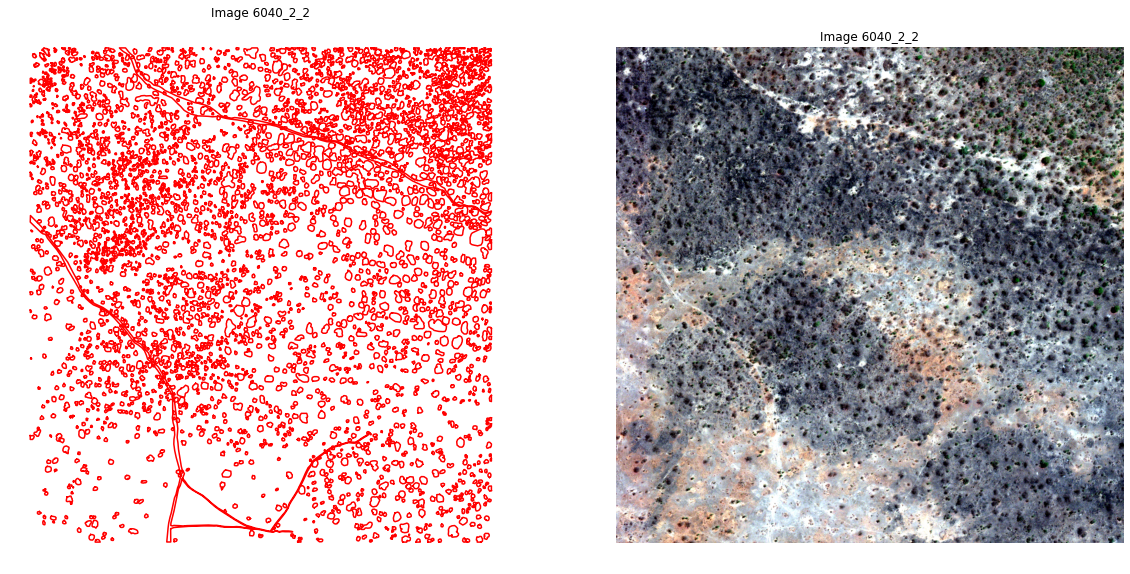

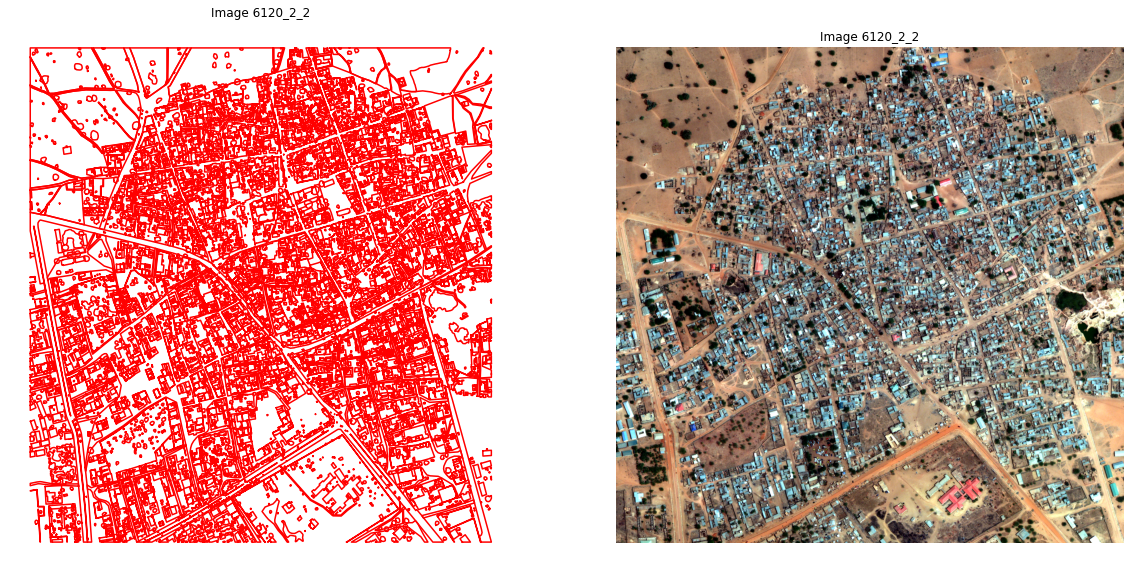

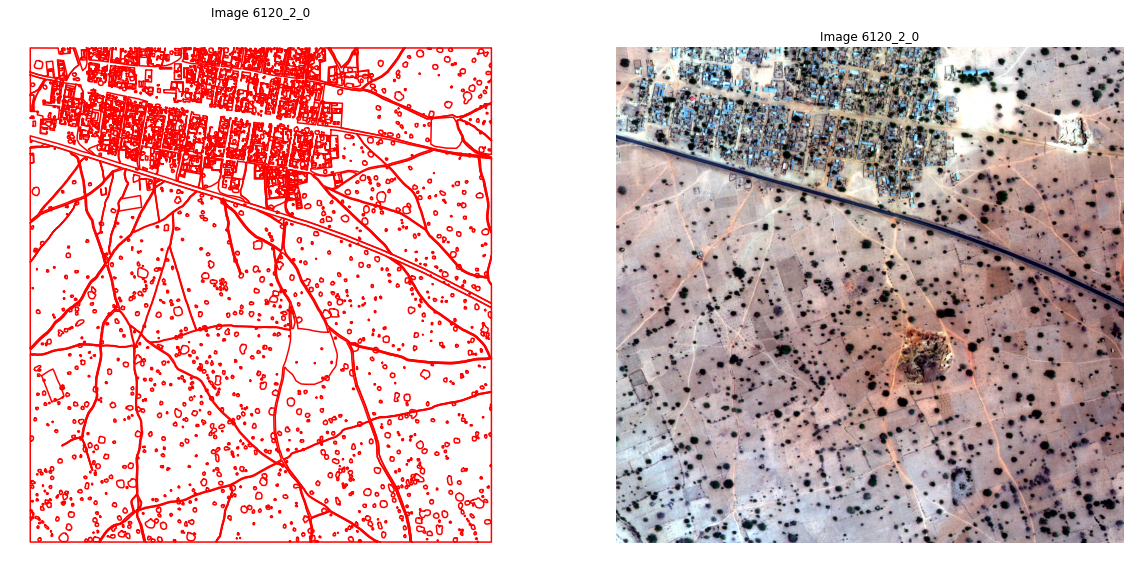

In [16]:
#plotting polygons for all the images and comparing with original images
c=0
for img_id in wkt_df['ImageId'].unique():
    df = wkt_df[wkt_df['ImageId']==img_id]
    fig, ax = plt.subplots(1, 2,figsize=(20, 10))  #increase figsize and run again
    for ele1 in df['Multipolygons']:
        for ele2 in ele1:
            x,y = ele2.exterior.xy
            ax[0].plot(x,y,'red')
            ax[0].axis('off')
    display_img(img_id)
    #ax[0].title(f"Image {wkt_df['ImageId'][i]}")
    ax[0].set_title(f"Image {img_id}")
    ax[1].set_title(f"Image {img_id}")
    ax[1].axis('off')
    plt.show()
    c += 1
    if c==3:
        break

In [11]:
#class labels in dictionary as key and value pair
class_label = {
    1:'Buildings',
    2:'Misc. Manmade structures',
    3:'Road',
    4:'Track',
    5:'Trees',
    6:'Crops',
    7:'Waterway',
    8:'Standing water',
    9:'Vehicle Large',
    10:'Vehicle Small'
}

In [12]:
def stretch2(band, lower_percent=2, higher_percent=98):
    '''
    Adjusting the contrast
    '''
    a = 0 #np.min(band)
    b = 255  #np.max(band)
    c = np.percentile(band, lower_percent)
    d = np.percentile(band, higher_percent)        
    out = a + (band - c) * (b - a) / (d - c)    
    out[out<a] = a
    out[out>b] = b
    return out

def adjust_contrast(x):    
    for i in range(3):
        x[:,:,i] = stretch2(x[:,:,i])
    return x.astype(np.uint8)  

def display_img(ImageID,ax):
    '''
    Displaying images
    '''
    rgbfile=os.path.join( 'three_band', '{}.tif'.format(ImageID))              
    rgb = tiff.imread(rgbfile)
    rgb = np.rollaxis(rgb, 0, 3)     
    x = adjust_contrast(rgb).copy()
    ax.imshow(x,extent=[0, 0.0092, -0.009, 0])

def mask_classes(imgID):
    '''
    getting polygon coordinate and ploting the polygon class wise seperately
    '''
    df = wkt_df[wkt_df['ImageId']==imgID]
    for class_l in df['ClassType']:
        fig, ax = plt.subplots(figsize=(5, 5))
        df1 = df[df['ClassType']==class_l]
        display_img(imgID,ax)
        for ele in df1['Multipolygons']:
            for ele2 in ele:
                x,y = ele2.exterior.xy
                ax.plot(x,y,'red')
        plt.title(f"Class Label :- {class_label[class_l]}")
        plt.axis('off')
        plt.show()

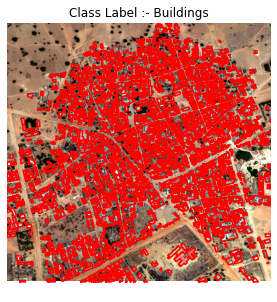

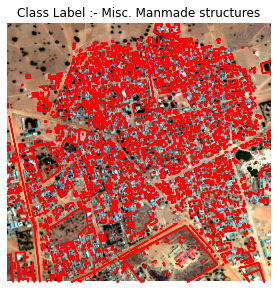

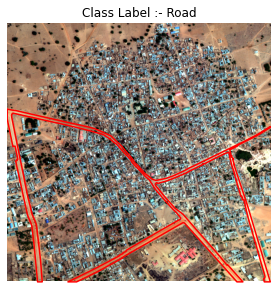

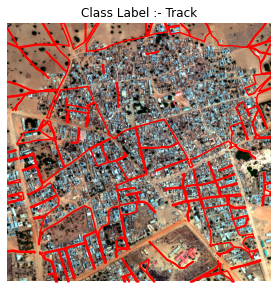

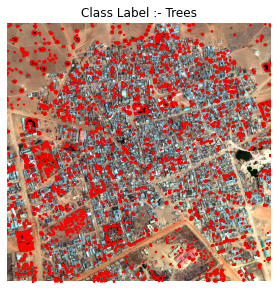

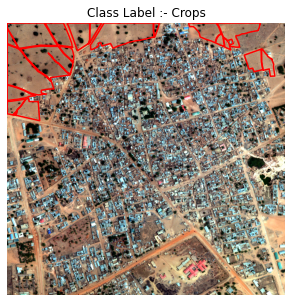

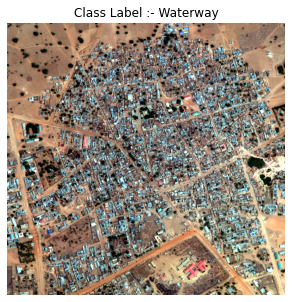

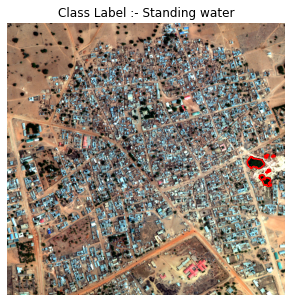

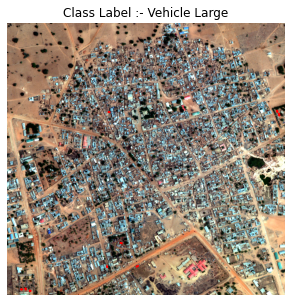

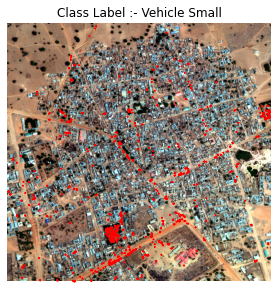

In [13]:
mask_classes('6120_2_2')

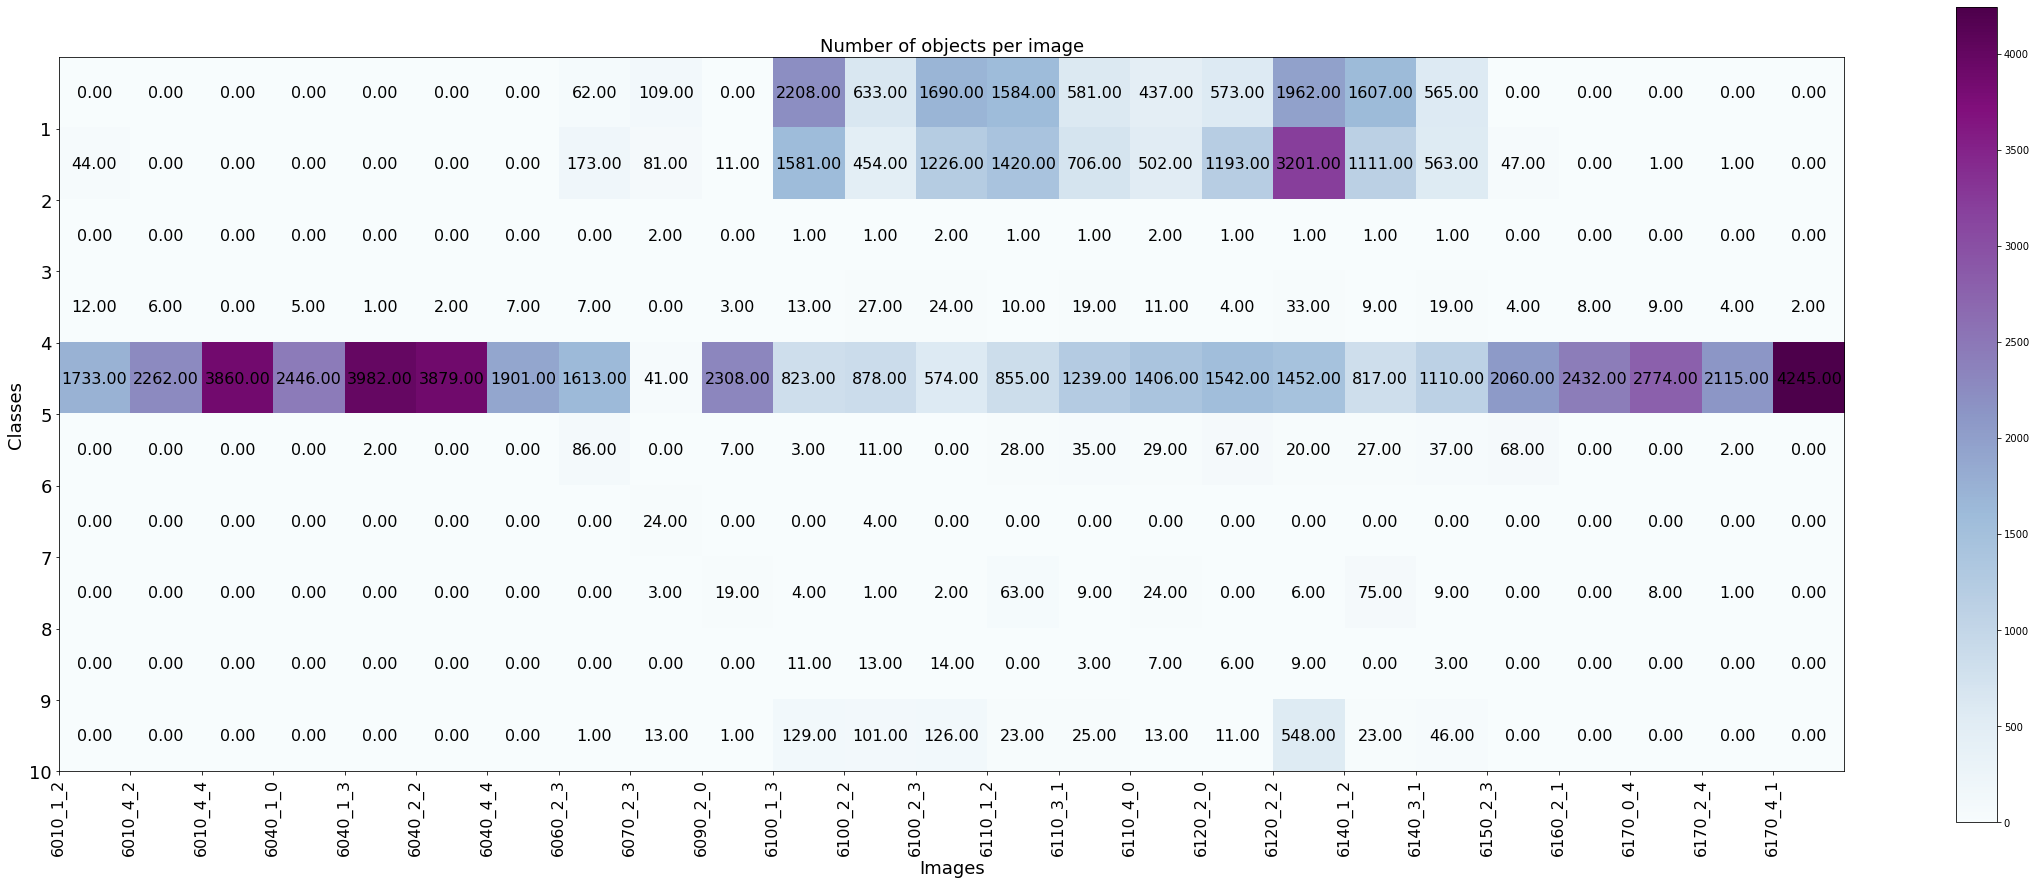

In [105]:
#heatmap plot of class frequncy vs images

%matplotlib inline
figure, axis = plt.subplots(figsize=(10, 8))
axis.set_aspect('equal')  #keep x-unit and y-unit ratio equal
plt.imshow(objects_per_image, cmap='BuPu', extent=[0, 25, 10, 0])

'''for i in range(objects_per_image.shape[0]):
    for j in range(objects_per_image.shape[1]):
        plt.text(j+0.5, i+0.5, "{:.2f}".format(objects_per_image.iloc[i,j]), ha="center", va="center",fontsize=16)'''

plt.xticks(np.arange(0, 25, 1.0),list(objects_per_image.columns), rotation='vertical',fontsize=16)
plt.yticks(np.arange(1, 11, 1.0),fontsize=18)
plt.title('Number of objects per image',fontsize=18)
plt.xlabel('Images',fontsize=18)
plt.ylabel('Classes',fontsize=18)
plt.colorbar()
plt.show()

In [14]:
Classes = {1: 'Building', 2: 'Structure', 3: 'Road', 4: 'Track', 5: 'Trees', 6: 'Crops', 7: 'Waterway', 8: 'Standing water', 9: 'Truck', 10: 'Car'}
Colors = {1:'#d73027' , 2: '#f46d43', 3: '#4575b4', 4:'#74add1' , 5: '#dfc27d', 6: '#a6dba0', 7: '#1b7837', 8: '#b35806', 9: '0.4',  10: '0.7'}

Trees have very high number of polygons

In [26]:
def image_stats(image_id):
    '''
    creating dataframe which contains 
    classes, number of polygon as counts and total area of image with id image_id
    '''
    counts, total_area = {}, {}
    xmax = GS[GS.ImageId == image_id].Xmax.values[0]
    ymin = GS[GS.ImageId == image_id].Ymin.values[0]
    image_area = abs(xmax * ymin) #area of image
    for cl in Classes:
        all_poly = wkt_df[wkt_df.ImageId == image_id]
        poly = all_poly[all_poly.ClassType == cl].MultipolygonWKT
        poly_list = wkt.loads(poly.values[0])
        counts[cl] = len(poly_list)  #number of polygons of classtype cl

        if len(poly_list) > 0:
            #calculating area of all polygon for class cl having number of polygons more than one
            total_area[cl] = np.sum([poly.area for poly in poly_list])\
                             / image_area * 100 
   
    df = pd.DataFrame({'Class': Classes, 'Counts': counts,
                         'TotalArea': total_area})
    return df 

In [27]:
GS = pd.read_csv('grid_sizes/grid_sizes.csv')
GS = GS.rename(columns={'Unnamed: 0':'ImageId'})

ImageId      Xmax     Ymin
0  6120_2_4  0.009180 -0.00904
1  6120_2_3  0.009169 -0.00904
2  6120_2_2  0.009188 -0.00904
3  6120_2_1  0.009188 -0.00904
4  6120_2_0  0.009188 -0.00904

In [28]:
stats_list = []
Images = sorted(set(wkt_df['ImageId']))
for image_no, image_id in enumerate(Images):
    stat = image_stats(image_id)
    stat['ImageId'] = image_id
    stats_list.append(stat)
        
stats = pd.concat(stats_list)
pvt_stats = stats.pivot(index = 'Class', columns = 'ImageId', values = 'TotalArea')
percent_area = np.cumsum(pvt_stats, axis = 0)

class_r = {}
for cl in Classes:
    class_r[Classes[cl]] = cl

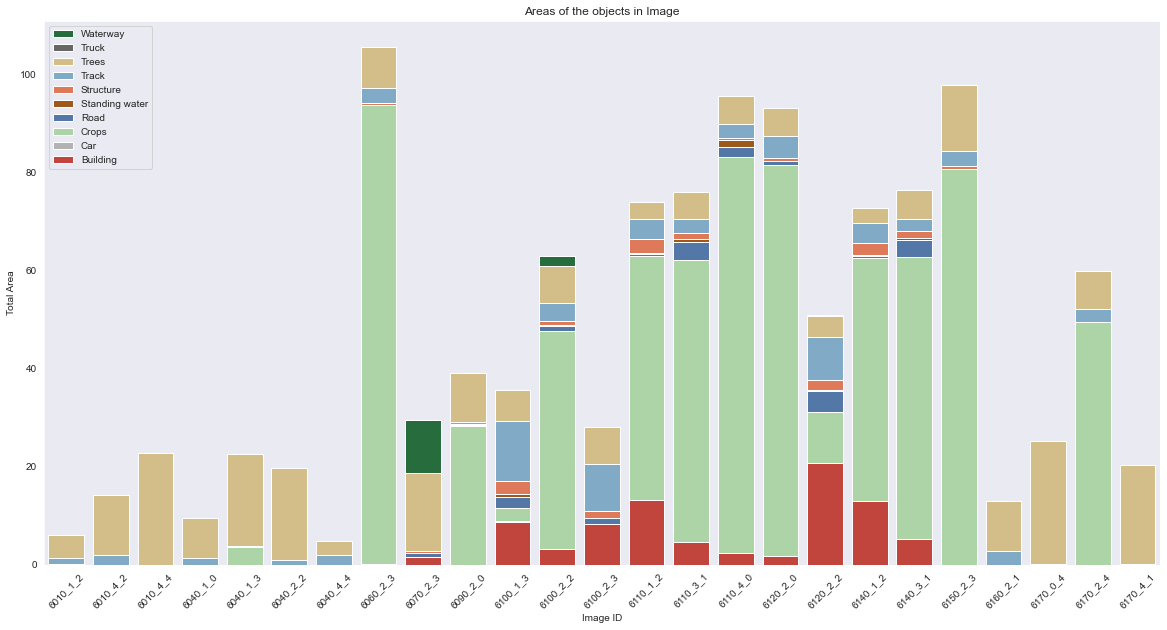

In [31]:
#iterating through all class to plot bar plot
for cl in np.arange(1, 11):
    class_name = percent_area.index[-cl]
    class_id = class_r[class_name]
    ax = sns.barplot(x = percent_area.columns, y = percent_area.loc[class_name],
                         color = Colors[class_id], label = class_name)

sns.set_context({'figure.figsize': (10, 5)})
ax.legend(loc = 2)
sns.set_style("dark")
ax.set_xticklabels(percent_area.columns, rotation = 45)

ax.set_xlabel('Image ID')
ax.set_ylabel('Total Area')
plt.title('Areas of the objects in Image')
plt.show()

Tress have heighest area coverd <br>
after which crops covers higher area <br>
water and vehicle covers lesser area <br>